In [123]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [124]:
#data path
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrAandNearby'
dpathalt='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_C'

#file name
fname='F0589_FO_IMA_07018927_FORF253_CAL_0138-0169_Field_P.fits'

#Name of field
field='FieldP'

#wavelength of data
wavelength=25.2

In [125]:
#change directory to data location
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

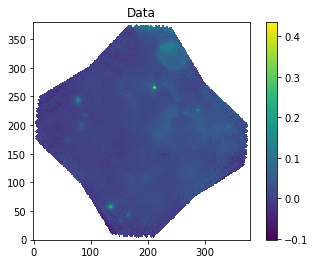

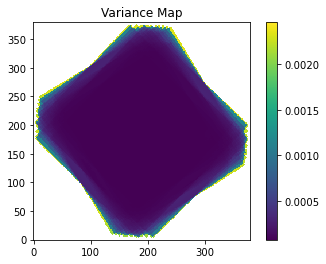

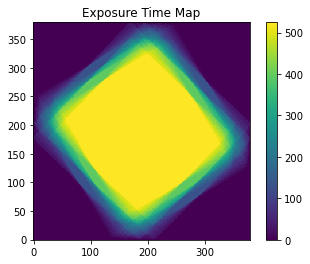

In [126]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

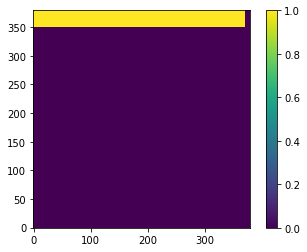

In [127]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.3,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
mask2[350:380,0:370]=1
mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [128]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

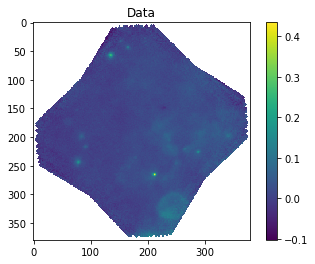

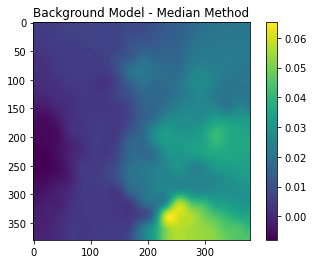

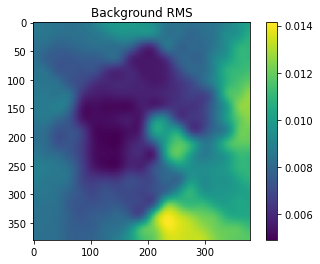

In [129]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [130]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

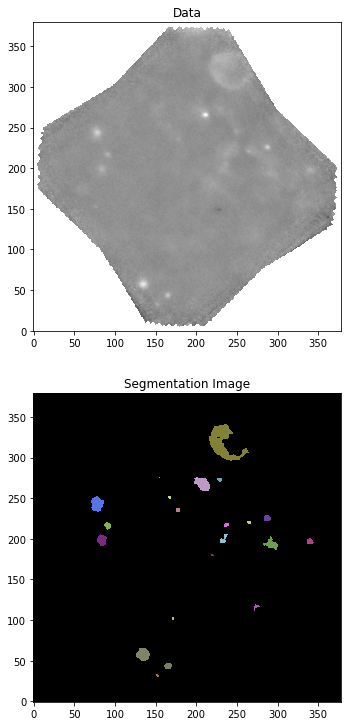

In [131]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [132]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,152.29453268364244,32.36921759324882,"266.5442093476321,-28.919578283490118",-0.0017551179811305818,0.007733892024504189,0.10054059631855446,13.0,1.1773576211773056,0.7962730044856515,-50.335538484506955,1.2285161244929532,0.8409502283151791,1.0700565571575518,0.7366059920665207,0.3236778781884354,1.4785853778099807,2.3666947008577965,1.1443555973597834,nan,2.5287123723268268,0.5401745408055072,nan
2,165.03760612009225,43.55926339614957,"266.54110330522235,-28.917191332695964",-0.0015523957272589818,0.010761027112546484,0.645661626752789,60.0,1.941553663022142,1.801841442163539,25.207647426990064,0.2730294407589802,-0.032933972131361594,0.300259986894192,0.3724780058807952,0.07195897982089905,1.0775385766967627,4.410579581619207,4.3114326356209824,nan,1.88923224529173,3.14176601842386,nan
3,134.8208683881209,57.64207257033497,"266.5484672495456,-28.914186273340455",0.002267229576028168,0.007564255944989107,1.5128511889978213,200.0,3.300093708747183,3.094635406906293,-52.160909333018466,0.09967882709278528,0.012205707560944338,0.09656268074816005,0.3473334827443573,0.06225832354284522,1.06639176343112,7.53310333014604,18.43676712893019,nan,1.6680688588372958,15.664061059136792,nan
4,171.10527422268257,102.07170419165385,"266.53962350245894,-28.904708779381235",0.004599214858249823,0.01650545413315617,0.13204363306524936,8.0,0.8545687005650274,0.6625287848525387,-43.30965003761002,1.796960096597612,0.9072878333386617,1.8505562336514796,0.6316194793056135,0.22472144789004667,1.2898589768522006,1.8004998219003798,2.0162404872256134,nan,3.8273246549332125,0.15130528489587125,nan
5,272.9378116103258,116.25288641443098,"266.5148082933797,-28.901682692631926",0.005827932668274816,0.024803409313058647,0.6200852328264662,25.0,2.1293417810252557,1.26881885820114,51.638292991437574,0.46685347536777216,-0.38989793476507173,0.3748537289404689,0.8030781293466462,0.4041262565231698,1.6782078602174284,4.127321016717395,6.784454089853159,nan,3.648897302535223,0.6051075934147886,nan
6,219.49984985452662,179.78473500987232,"266.5278307414513,-28.88813020225057",0.017157062582689436,0.026904679411209415,0.26904679411209415,10.0,0.9925058076825475,0.7460917230799979,-6.759885426372726,1.0259836599731689,0.18265140689390735,1.7856266572746629,0.659476366378256,0.24827470297419663,1.3302731781895514,2.067500242434262,4.974915406898891,nan,3.8678563649499274,0.333545953546397,nan
7,292.10615491957924,193.56018720743396,"266.5101406510599,-28.88518981688879",0.020219059192050477,0.032761516785008445,4.586612349901182,140.0,4.35439685844717,2.9992021733062697,-26.79879244291433,0.06461769673522232,0.047028293354263985,0.0992930048148698,0.7249746310830616,0.3112244311199919,1.4518517281704142,8.804001965456164,19.51439765678404,nan,3.1871618210540147,4.067953248914497,nan
8,84.2055457787298,198.57016205077505,"266.560794373157,-28.88411950436042",0.0206987620703811,0.0029868967137638117,0.3733620892204765,125.0,3.1025208249527987,2.6743775186228795,-77.57880721680067,0.13815308772434043,0.015093363622645453,0.1055514170174448,0.5069057722445148,0.13799852780567,1.1600908261262919,6.820432619156914,8.687958044631278,nan,2.4309967411804525,4.366986154865432,nan


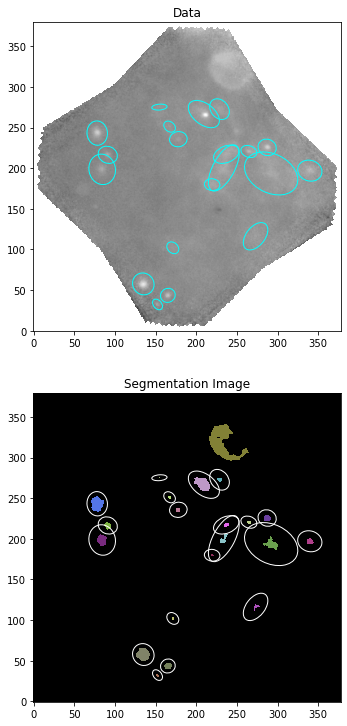

In [133]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

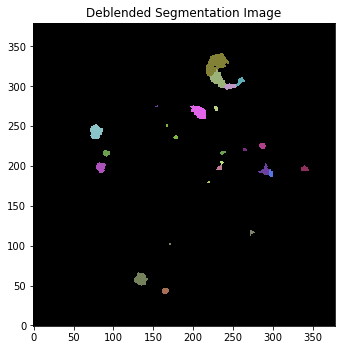

In [134]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [135]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,152.29453268364244,32.36921759324882,"266.5442093476321,-28.919578283490118",-0.0017551179811305818,0.007733892024504189,0.10054059631855446,13.0,1.1773576211773056,0.7962730044856515,-50.335538484506955,1.2285161244929532,0.8409502283151791,1.0700565571575518,0.7366059920665207,0.3236778781884354,1.4785853778099807,2.3666947008577965,1.1443555973597834,nan,2.5287123723268268,0.5401745408055072,nan
2,165.03760612009225,43.55926339614957,"266.54110330522235,-28.917191332695964",-0.0015523957272589818,0.010761027112546484,0.645661626752789,60.0,1.941553663022142,1.801841442163539,25.207647426990064,0.2730294407589802,-0.032933972131361594,0.300259986894192,0.3724780058807952,0.07195897982089905,1.0775385766967627,4.410579581619207,4.3114326356209824,nan,1.88923224529173,3.14176601842386,nan
3,134.8208683881209,57.64207257033497,"266.5484672495456,-28.914186273340455",0.002267229576028168,0.007564255944989107,1.5128511889978213,200.0,3.300093708747183,3.094635406906293,-52.160909333018466,0.09967882709278528,0.012205707560944338,0.09656268074816005,0.3473334827443573,0.06225832354284522,1.06639176343112,7.53310333014604,18.43676712893019,nan,1.6680688588372958,15.664061059136792,nan
4,171.10527422268257,102.07170419165385,"266.53962350245894,-28.904708779381235",0.004599214858249823,0.01650545413315617,0.13204363306524936,8.0,0.8545687005650274,0.6625287848525387,-43.30965003761002,1.796960096597612,0.9072878333386617,1.8505562336514796,0.6316194793056135,0.22472144789004667,1.2898589768522006,1.8004998219003798,2.0162404872256134,nan,3.8273246549332125,0.15130528489587125,nan
5,272.9378116103258,116.25288641443098,"266.5148082933797,-28.901682692631926",0.005827932668274816,0.024803409313058647,0.6200852328264662,25.0,2.1293417810252557,1.26881885820114,51.638292991437574,0.46685347536777216,-0.38989793476507173,0.3748537289404689,0.8030781293466462,0.4041262565231698,1.6782078602174284,4.127321016717395,6.784454089853159,nan,3.648897302535223,0.6051075934147886,nan
6,219.49984985452662,179.78473500987232,"266.5278307414513,-28.88813020225057",0.017157062582689436,0.026904679411209415,0.26904679411209415,10.0,0.9925058076825475,0.7460917230799979,-6.759885426372726,1.0259836599731689,0.18265140689390735,1.7856266572746629,0.659476366378256,0.24827470297419663,1.3302731781895514,2.067500242434262,4.974915406898891,nan,3.8678563649499274,0.333545953546397,nan
7,84.2055457787298,198.57016205077505,"266.560794373157,-28.88411950436042",0.0206987620703811,0.0029868967137638117,0.3733620892204765,125.0,3.1025208249527987,2.6743775186228795,-77.57880721680067,0.13815308772434043,0.015093363622645453,0.1055514170174448,0.5069057722445148,0.13799852780567,1.1600908261262919,6.820432619156914,8.687958044631278,nan,2.4309967411804525,4.366986154865432,nan
8,339.65507475593796,197.00284644111656,"266.4985558101769,-28.884453068837345",0.010412978090918327,0.037408642051459676,2.0574753128302823,55.0,2.2158660946575766,1.8524018025062825,-18.224002845265197,0.21224682422085328,0.05213968011811815,0.28284345131242605,0.5487722409553487,0.1640280940385349,1.1962124478930707,4.809098046940283,6.512305163818166,nan,2.7370791392258793,2.4239093668448195,nan


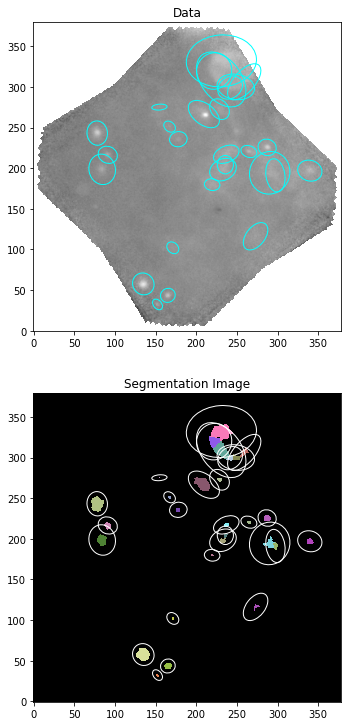

In [136]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [137]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [138]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [139]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,152.29453268364244,32.36921759324882,"266.5442093476321,-28.919578283490118",-0.0017551179811305818,0.007733892024504189,0.10054059631855446,13.0,1.1773576211773056,0.7962730044856515,-50.335538484506955,1.2285161244929532,0.8409502283151791,1.0700565571575518,0.7366059920665207,0.3236778781884354,1.4785853778099807,2.3666947008577965,1.1443555973597834,0.17770640103588478,2.5287123723268268,0.5401745408055072,0.057527974,0.007756623818824131,0.007749332439474857,0.0001807679097007435,1.3577999119778361
2,165.03760612009225,43.55926339614957,"266.54110330522235,-28.917191332695964",-0.0015523957272589818,0.010761027112546484,0.645661626752789,60.0,1.941553663022142,1.801841442163539,25.207647426990064,0.2730294407589802,-0.032933972131361594,0.300259986894192,0.3724780058807952,0.07195897982089905,1.0775385766967627,4.410579581619207,4.3114326356209824,0.16709996603692281,1.88923224529173,3.14176601842386,0.081190005,0.010726099357159893,0.010765405101628524,0.00050661938105548,3.6844485110323584
3,134.8208683881209,57.64207257033497,"266.5484672495456,-28.914186273340455",0.002267229576028168,0.007564255944989107,1.5128511889978213,200.0,3.300093708747183,3.094635406906293,-52.160909333018466,0.09967882709278528,0.012205707560944338,0.09656268074816005,0.3473334827443573,0.06225832354284522,1.06639176343112,7.53310333014604,18.43676712893019,0.3470066565463048,1.6680688588372958,15.664061059136792,0.19760507,0.0076232747446832085,0.007514612275721351,0.0007986320720656233,12.011922844557356
4,171.10527422268257,102.07170419165385,"266.53962350245894,-28.904708779381235",0.004599214858249823,0.01650545413315617,0.13204363306524936,8.0,0.8545687005650274,0.6625287848525387,-43.30965003761002,1.796960096597612,0.9072878333386617,1.8505562336514796,0.6316194793056135,0.22472144789004667,1.2898589768522006,1.8004998219003798,2.0162404872256134,0.1103717906327701,3.8273246549332125,0.15130528489587125,0.02445729,0.01650599829666302,0.016508023068082616,0.00036487967942870327,0.3824433654346965
5,272.9378116103258,116.25288641443098,"266.5148082933797,-28.901682692631926",0.005827932668274816,0.024803409313058647,0.6200852328264662,25.0,2.1293417810252557,1.26881885820114,51.638292991437574,0.46685347536777216,-0.38989793476507173,0.3748537289404689,0.8030781293466462,0.4041262565231698,1.6782078602174284,4.127321016717395,6.784454089853159,0.2478047346629447,3.648897302535223,0.6051075934147886,0.046834618,0.02511088161878374,0.025124965568095167,0.0005052000488692564,0.7365360098300759
6,219.49984985452662,179.78473500987232,"266.5278307414513,-28.88813020225057",0.017157062582689436,0.026904679411209415,0.26904679411209415,10.0,0.9925058076825475,0.7460917230799979,-6.759885426372726,1.0259836599731689,0.18265140689390735,1.7856266572746629,0.659476366378256,0.24827470297419663,1.3302731781895514,2.067500242434262,4.974915406898891,0.12495586659582919,3.8678563649499274,0.333545953546397,0.026757631,0.02698400786231826,0.02698811697582946,0.0005353198400990887,0.6124091877499889
7,84.2055457787298,198.57016205077505,"266.560794373157,-28.88411950436042",0.0206987620703811,0.0029868967137638117,0.3733620892204765,125.0,3.1025208249527987,2.6743775186228795,-77.57880721680067,0.13815308772434043,0.015093363622645453,0.1055514170174448,0.5069057722445148,0.13799852780567,1.1600908261262919,6.820432619156914,8.687958044631278,0.2699010831

In [140]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [141]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,152.29453268328334,32.36921759309939,"266.5442093476321,-28.919578283490118",0.701719749499256,0.07466016823809828,1.1194875704522798,0.1518149452764948,1.0073539670303953,0.2302485334520814,0.15583843002288622,0.30892100448826465,-1.0887203080272974,0.39034181577233584
2,165.03760612016964,43.5592633960583,"266.54110330522235,-28.917191332695964",1.729143717529346,0.048670322300194246,3.5423056154547674,0.0970294862640347,4.179199861020198,0.1468464270016679,4.359796073580169,0.1988173860040777,4.321550171861201,0.25272391175299264
3,134.8208683881715,57.64207257030753,"266.5484672495456,-28.914186273340455",4.298758935178378,0.06451093171009331,11.004974977087846,0.12908092227510493,15.293033977344397,0.1948857907155013,17.411735437439596,0.2645230148388525,18.405054458755032,0.3395305789220832
4,171.10527422255535,102.0717041915496,"266.53962350245894,-28.904708779381235",0.3826549443807871,0.039915763232070425,1.219738574876414,0.07986332187511093,2.240162786952526,0.11976456050004315,3.1112573081243733,0.15966780875776532,3.934145471367992,0.19954681221216156
5,272.9378116103349,116.25288641440206,"266.5148082933797,-28.901682692631926",0.4669540533212583,0.0431900238609754,1.5579169052444517,0.08607251657503066,2.9737299304043505,0.12908193814666938,4.628079970833484,0.17204122347253456,6.088264266652885,0.21500891581375167
6,219.49984985462783,179.7847350098368,"266.5278307414513,-28.88813020225057",0.6788795411212507,0.039056304961527094,2.340888105311752,0.07814470690615204,4.483607183002309,0.117296359575789,7.050139473867693,0.15653915684118122,9.56008932427399,0.19571691230558555
7,84.20554577866007,198.57016205074993,"266.560794373157,-28.88411950436042",1.1843030959891205,0.040214840632487966,3.4119484195288923,0.08038780297005577,5.363770328545848,0.12054280432766672,6.737243638809975,0.16069549974350805,7.8230295357825606,0.20082765100429684
8,339.65507475597394,197.00284644109652,"266.4985558101769,-28.884453068837345",1.1245185035459722,0.06066522142305758,3.1271533448975766,0.1227556803133255,4.928459696022083,0.18728042186188745,5.93292922451,0.2579116389958463,6.360656469580503,0.33538576330349734


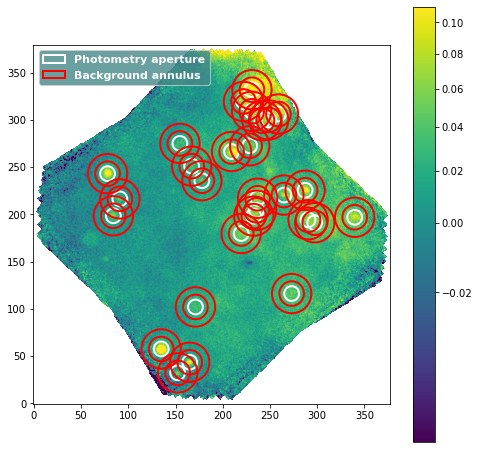

In [142]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [143]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [144]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-144-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,152.29453268328334,32.36921759309939,"266.5442093476321,-28.919578283490118",1.0073539670303953,0.2302485334520814,-0.003581420517799909,-0.005519961490414274,1.694082738597835,0.2302485334520814,0.0,3.182349439377051
2,165.03760612016964,43.5592633960583,"266.54110330522235,-28.917191332695964",4.179199861020198,0.1468464270016679,-0.001577054134790798,-0.0022556419628453435,4.481596198813431,0.1468464270016679,0.0,10.54175008177638
3,134.8208683881715,57.64207257030753,"266.5484672495456,-28.914186273340455",15.293033977344397,0.1948857907155013,8.721943823610031e-05,-0.0002616865031590212,15.276309859810866,0.1948857907155013,8.721943823610034e-05,29.933820100650966
4,171.10527422255535,102.0717041915496,"266.53962350245894,-28.904708779381235",2.240162786952526,0.11976456050004315,0.0010435233591252883,0.0013163421522098151,2.0400696923403747,0.11976456050004315,0.0010435233591252883,3.2514592408572005
5,272.9378116103349,116.25288641440206,"266.5148082933797,-28.901682692631926",2.9737299304043505,0.12908193814666938,0.0028716241534023287,0.0033066628770691536,2.4231029047679415,0.12908193814666938,0.0028716241534023287,2.649244518404011
6,219.49984985462783,179.7847350098368,"266.5278307414513,-28.88813020225057",4.483607183002309,0.117296359575789,0.005478735111576594,0.00564581537573281,3.4330729008042318,0.117296359575789,0.005478735111576594,2.8635500447074413
7,84.20554577866007,198.57016205074993,"266.560794373157,-28.88411950436042",5.363770328545848,0.12054280432766672,0.00013481947279754813,0.00035398455762524855,5.337919018855327,0.12054280432766672,0.0001348194727975481,12.575401442289198
8,339.65507475597394,197.00284644109652,"266.4985558101769,-28.884453068837345",4.928459696022083,0.18728042186188745,-2.6116296995590154e-06,-0.00023824330657162008,4.928960469736438,0.18728042186188745,0.0,10.266462625564772


In [145]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [146]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,152.29453268364244,32.36921759324882,"266.5442093476321,-28.919578283490118",-0.0017551179811305818,0.007733892024504189,0.10054059631855446,13.0,1.1773576211773056,0.7962730044856515,-50.335538484506955,1.2285161244929532,0.8409502283151791,1.0700565571575518,0.7366059920665207,0.3236778781884354,1.4785853778099807,2.3666947008577965,1.1443555973597834,0.17770640103588478,2.5287123723268268,0.5401745408055072,0.057527974,0.007756623818824131,0.007749332439474857,0.0001807679097007435,1.3577999119778361,0.701719749499256,0.07466016823809828,1.1194875704522798,0.1518149452764948,1.0073539670303953,0.2302485334520814,0.15583843002288622,0.30892100448826465,-1.0887203080272974,0.39034181577233584,-0.003581420517799909,-0.005519961490414274,1.694082738597835,0.2302485334520814,0.0,3.182349439377051,0.7780229463400826,1.4247003578155863,1.376689579476113,0.8188596129933696,2.811578616497044,3.482285266986142,2.0857548625956435,1.0231262545798756,3.482285266986142,C7FieldP,25.2
2,165.03760612009225,43.55926339614957,"266.54110330522235,-28.917191332695964",-0.0015523957272589818,0.010761027112546484,0.645661626752789,60.0,1.941553663022142,1.801841442163539,25.207647426990064,0.2730294407589802,-0.032933972131361594,0.300259986894192,0.3724780058807952,0.07195897982089905,1.0775385766967627,4.410579581619207,4.3114326356209824,0.16709996603692281,1.88923224529173,3.14176601842386,0.081190005,0.010726099357159893,0.010765405101628524,0.00050661938105548,3.6844485110323584,1.729143717529346,0.048670322300194246,3.5423056154547674,0.0970294862640347,4.179199861020198,0.1468464270016679,4.359796073580169,0.1988173860040777,4.321550171861201,0.25272391175299264,-0.001577054134790798,-0.0022556419628453435,4.481596198813431,0.1468464270016679,0.0,10.54175008177638,1.7627433106174832,3.6767039878073153,4.8973895629903605,5.161539999064626,7.8896778768638525,11.240998138235332,9.248864787137899,8.01490623885485,11.240998138235332,C7FieldP,25.2
3,134.8208683881209,57.64207257033497,"266.5484672495456,-28.914186273340455",0.002267229576028168,0.007564255944989107,1.5128511889978213,200.0,3.300093708747183,3.094635406906293,-52.160909333018466,0.09967882709278528,0.012205707560944338,0.09656268074816005,0.3473334827443573,0.06225832354284522,1.06639176343112,7.53310333014604,18.43676712893019,0.3470066565463048,1.6680688588372958,15.664061059136792,0.19760507,0.0076232747446832085,0.007514612275721351,0.0007986320720656233,12.011922844557356,4.298758935178378,0.06451093171009331,11.004974977087846,0.12908092227510493,15.293033977344397,0.1948857907155013,17.411735437439596,0.2645230148388525,18.405054458755032,0.3395305789220832,8.721943823610031e-05,-0.0002616865031590212,15.27630

In [147]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [148]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
2,165.03760612009225,43.55926339614957,"266.54110330522235,-28.917191332695964",-0.0015523957272589818,0.010761027112546484,0.645661626752789,60.0,1.941553663022142,1.801841442163539,25.207647426990064,0.2730294407589802,-0.032933972131361594,0.300259986894192,0.3724780058807952,0.07195897982089905,1.0775385766967627,4.410579581619207,4.3114326356209824,0.16709996603692281,1.88923224529173,3.14176601842386,0.081190005,0.010726099357159893,0.010765405101628524,0.00050661938105548,3.6844485110323584,1.729143717529346,0.048670322300194246,3.5423056154547674,0.0970294862640347,4.179199861020198,0.1468464270016679,4.359796073580169,0.1988173860040777,4.321550171861201,0.25272391175299264,-0.001577054134790798,-0.0022556419628453435,4.481596198813431,0.1468464270016679,0.0,10.54175008177638,1.7627433106174832,3.6767039878073153,4.8973895629903605,5.161539999064626,7.8896778768638525,11.240998138235332,9.248864787137899,8.01490623885485,11.240998138235332,C7FieldP,25.2
3,134.8208683881209,57.64207257033497,"266.5484672495456,-28.914186273340455",0.002267229576028168,0.007564255944989107,1.5128511889978213,200.0,3.300093708747183,3.094635406906293,-52.160909333018466,0.09967882709278528,0.012205707560944338,0.09656268074816005,0.3473334827443573,0.06225832354284522,1.06639176343112,7.53310333014604,18.43676712893019,0.3470066565463048,1.6680688588372958,15.664061059136792,0.19760507,0.0076232747446832085,0.007514612275721351,0.0007986320720656233,12.011922844557356,4.298758935178378,0.06451093171009331,11.004974977087846,0.12908092227510493,15.293033977344397,0.1948857907155013,17.411735437439596,0.2645230148388525,18.405054458755032,0.3395305789220832,8.721943823610031e-05,-0.0002616865031590212,15.276309859810866,0.1948857907155013,8.721943823610034e-05,29.933820100650966,4.296900699896875,10.997542035961832,17.382003672935543,18.358598576717448,16.469273501507875,28.34688407151672,26.982925444843513,23.067249156892764,29.933820100650966,C7FieldP,25.2
7,84.2055457787298,198.57016205077505,"266.560794373157,-28.88411950436042",0.0206987620703811,0.0029868967137638117,0.3733620892204765,125.0,3.1025208249527987,2.6743775186228795,-77.57880721680067,0.13815308772434043,0.015093363622645453,0.1055514170174448,0.5069057722445148,0.13799852780567,1.1600908261262919,6.820432619156914,8.687958044631278,0.26990108314458394,2.4309967411804525,4.366986154865432,0.09734226,0.0029707932756563773,0.003043531948240934,0.00045385666102687493,6.317803672412262,1.1843030959891205,0.040214840632487966,3.4119484195288923,0.08038780297005577,5.363770328545848,0.12054280432766672,6.737243638809975,0.16069549974350805,7.8230295357825606,0.20082765100429684,0.00013481947279754813,0.00035398455762

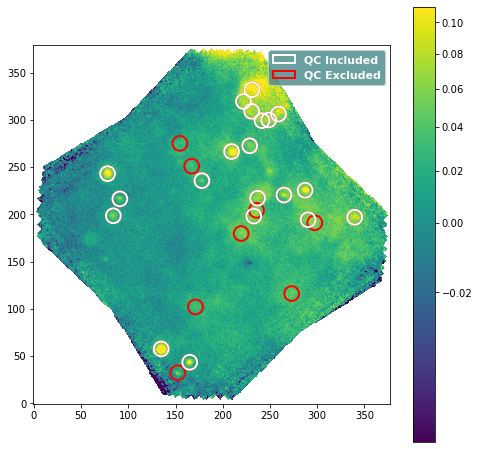

In [149]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

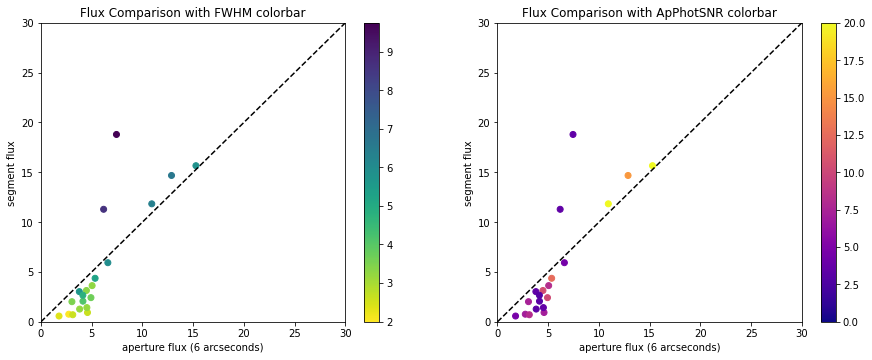

In [150]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

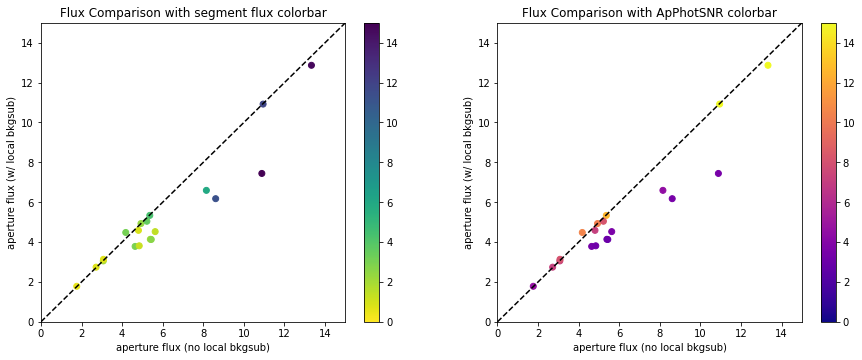

In [151]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [152]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)